In [8]:
# Importing required libraries for data manipulation, visualization, preprocessing, modeling, and evaluation
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical operations
import seaborn as sns  # Statistical data visualization
import matplotlib.pyplot as plt  # General plotting

# Scikit-learn modules for preprocessing, model building, and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV  # Splitting and tuning
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Feature scaling and encoding
from sklearn.impute import SimpleImputer  # Handling missing values
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Ensemble models
from sklearn.metrics import classification_report, confusion_matrix  # Model performance evaluation

# TensorFlow Keras modules for deep learning model
from tensorflow.keras.models import Sequential  # Model architecture
from tensorflow.keras.layers import Dense, Dropout  # Layers for the neural network
from tensorflow.keras.callbacks import EarlyStopping  # Stop training when validation stops improving
from tensorflow.keras.optimizers import Adam  # Optimizer for model training

# Load the dataset and sample a subset to speed up processing during development
df = pd.read_csv('data/credit_risk_dataset.csv')  # Load dataset from specified path
df = df.sample(frac=0.2, random_state=42)  # Use 20% of the data for quicker iteration (random but reproducible)

# Basic data overview to understand structure and content
print("Data Overview:")
print(df.head())  # Display the first 5 rows

print("\nData Summary:")
print(df.info())  # Show data types and non-null counts

print("\nMissing Values:")
print(df.isnull().sum())  # Count missing values in each column

# Separate features based on data type
numerical_cols = df.select_dtypes(include=[np.number]).columns  # Identify numerical features
categorical_cols = df.select_dtypes(include=['object']).columns  # Identify categorical features

Data Overview:
,       person_age  person_income person_home_ownership  person_emp_length  \
,14668          24          28000                   OWN                6.0   
,24614          27          64000                  RENT                0.0   
,11096          26          72000              MORTGAGE               10.0   
,10424          23          27996                  RENT                7.0   
,26007          30          44500                  RENT                2.0   
,
,             loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
,14668    HOMEIMPROVEMENT          B      10000          10.37            0   
,24614           PERSONAL          C      10000          15.27            0   
,11096          EDUCATION          D      16000            NaN            0   
,10424  DEBTCONSOLIDATION          A      10000            NaN            1   
,26007            MEDICAL          E      13000          16.32            1   
,
,       loan_percent_income cb_person_d

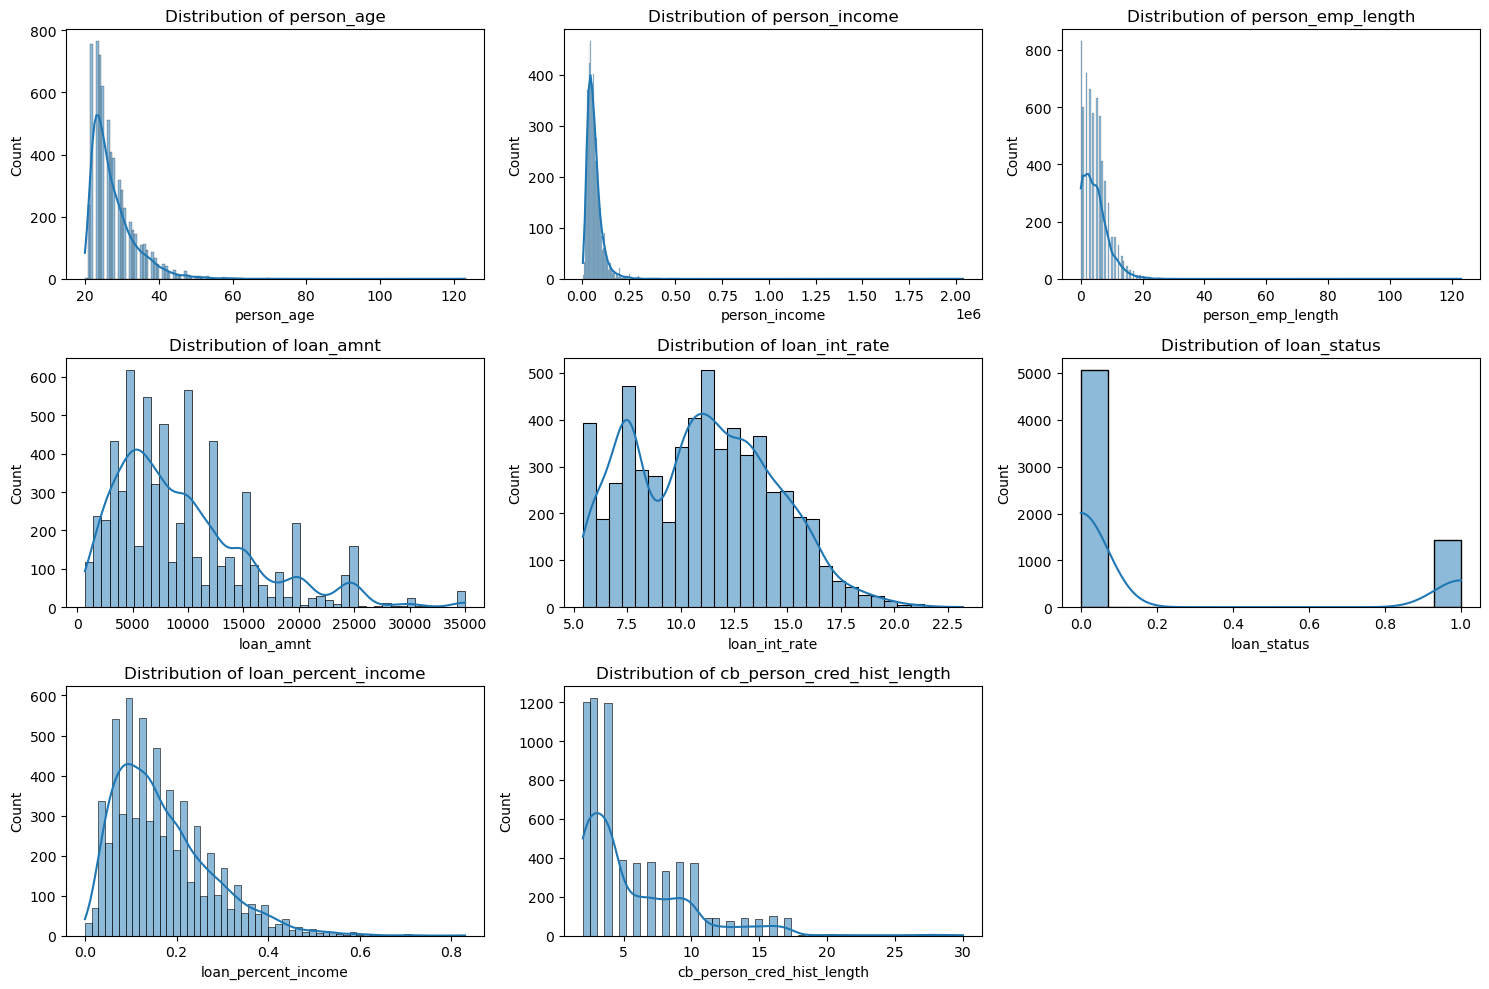

In [9]:
# Visualizing the distribution of numerical features in the dataset

#Set the overall figure size for the grid of subplots
plt.figure(figsize=(15, 10))

# Loop through each numerical column and create a histogram with a KDE (kernel density estimate)
for i, col in enumerate(numerical_cols, 1):  # Start enumeration at 1 for subplot indexing
    plt.subplot(3, 3, i)  # Create a 3x3 grid of subplots (adjust as needed based on number of columns)
    sns.histplot(df[col], kde=True)  # Plot histogram and density curve for the feature
    plt.title(f'Distribution of {col}')  # Set title for each subplot

# Adjust subplot layout to prevent overlapping elements
plt.tight_layout()

# Display the plots
plt.show()

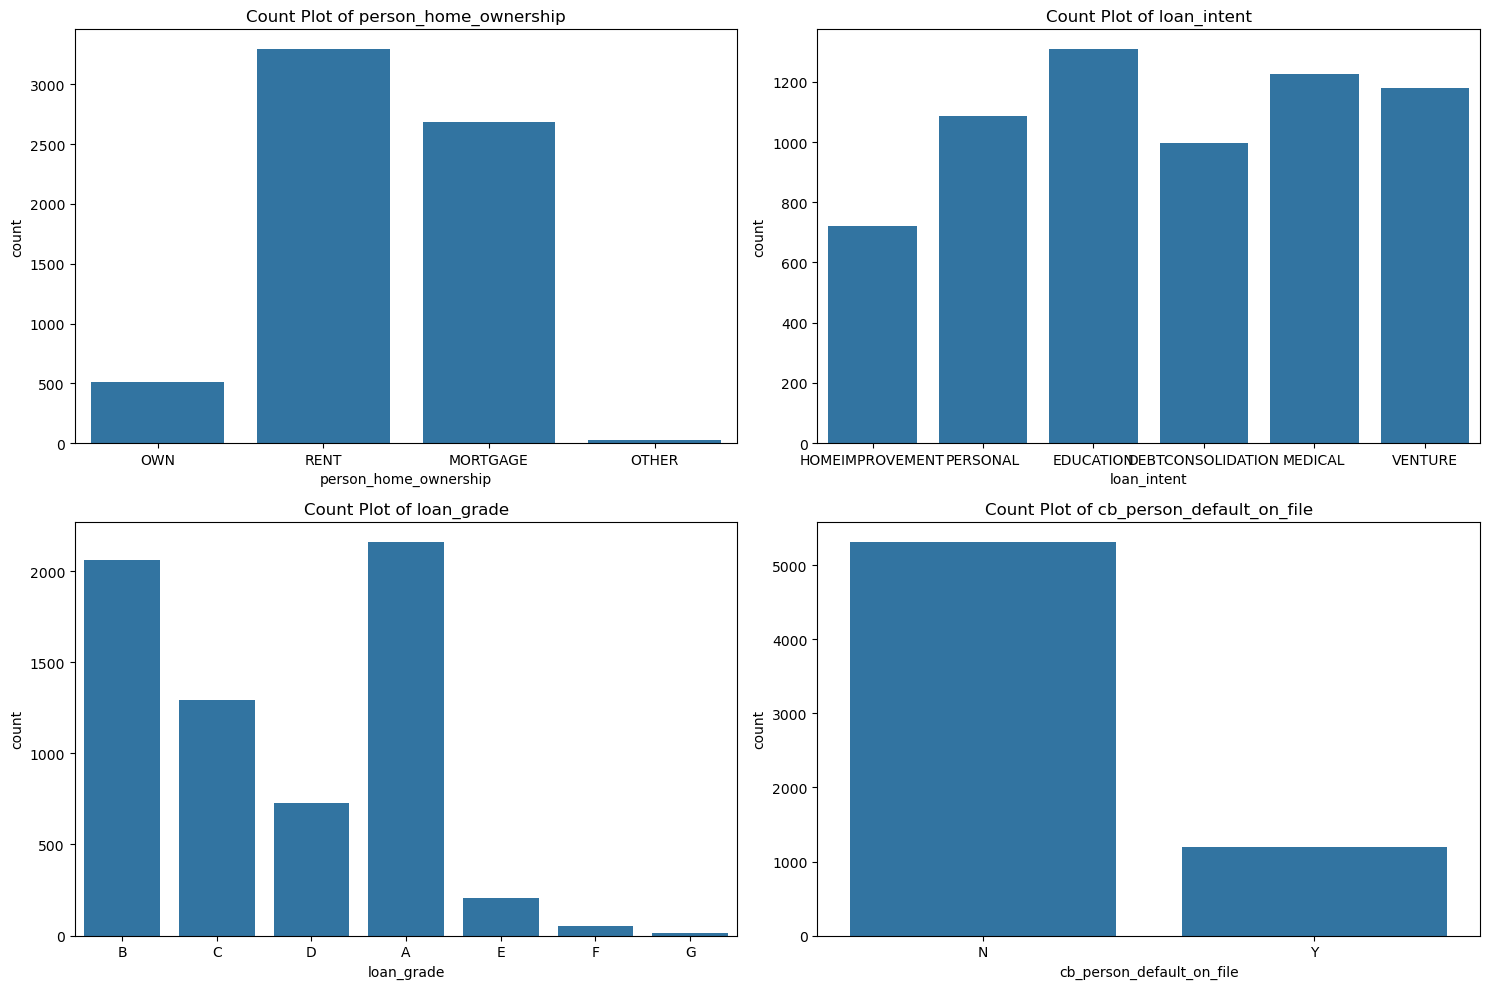

In [10]:
# Visualizing the distribution (counts) of categorical variables

# Set the overall figure size for the grid of subplots
plt.figure(figsize=(15, 10))

# Loop through each categorical column and create a count plot
for i, col in enumerate(categorical_cols, 1):  # Start indexing at 1 for subplot positioning
    plt.subplot(2, 2, i)  # Create a 2x2 grid of subplots (adjust if more than 4 categories)
    sns.countplot(x=col, data=df)  # Plot the count of each unique category value
    plt.title(f'Count Plot of {col}')  # Set a title for each subplot

# Adjust layout to prevent label and title overlap
plt.tight_layout()

# Display all the subplots
plt.show()

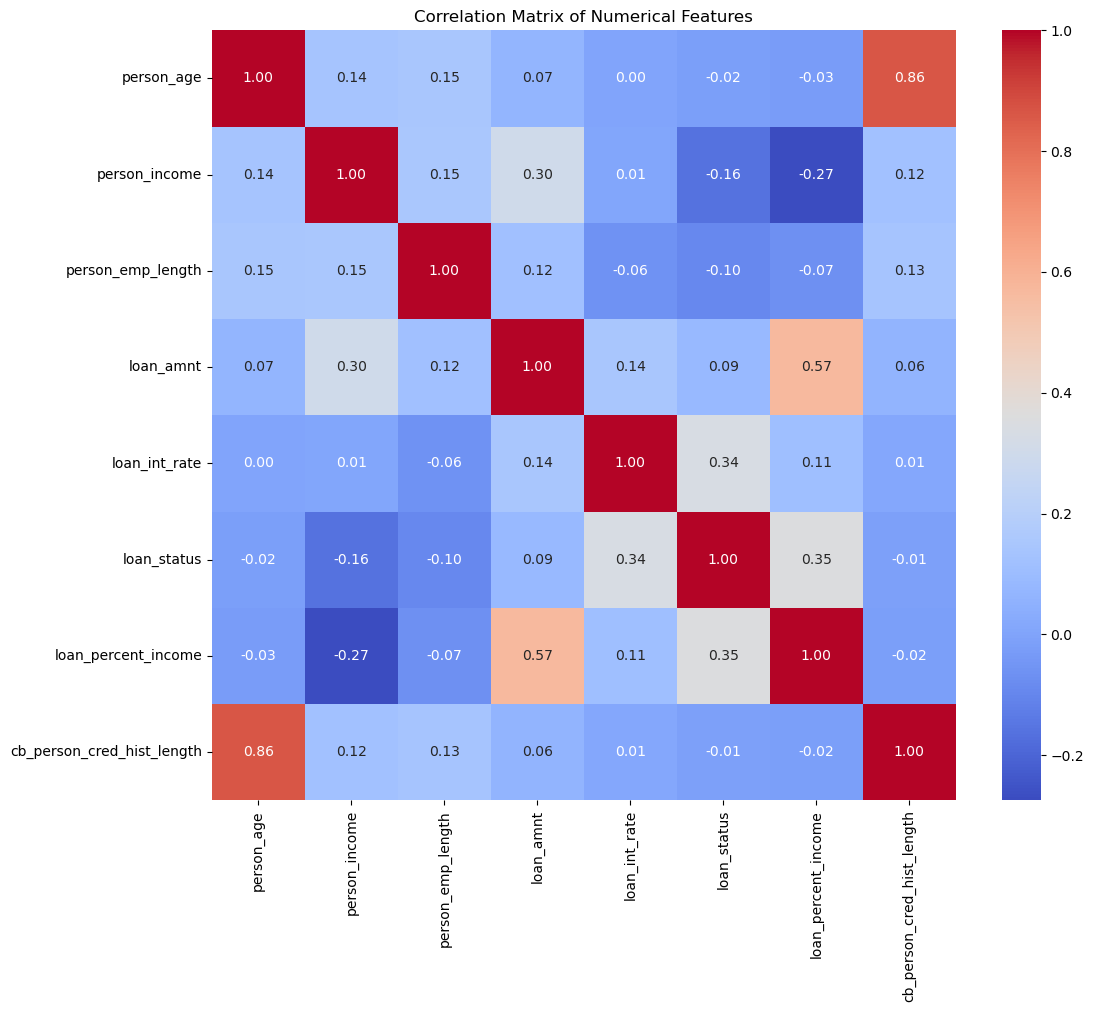

In [11]:
# Handling Missing Values

# Drop columns with more than 30% missing values
missing_threshold = 0.3
df = df.dropna(thresh=len(df) * (1 - missing_threshold), axis=1)

# Initialize imputers:
# - Numerical columns: fill missing values with the mean
# - Categorical columns: fill missing values with the most frequent value (mode)
imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

# Apply imputers to respective column types
df[numerical_cols] = imputer_num.fit_transform(df[numerical_cols])
df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

# Correlation Heatmap for Numerical Features

# Extract only numeric features for correlation analysis
numerical_df = df.select_dtypes(include=[np.number])

# Set the size of the heatmap figure
plt.figure(figsize=(12, 10))

# Generate a heatmap to visualize correlations between numeric features
sns.heatmap(numerical_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Add title to the heatmap
plt.title('Correlation Matrix of Numerical Features')

# Display the plot
plt.show()

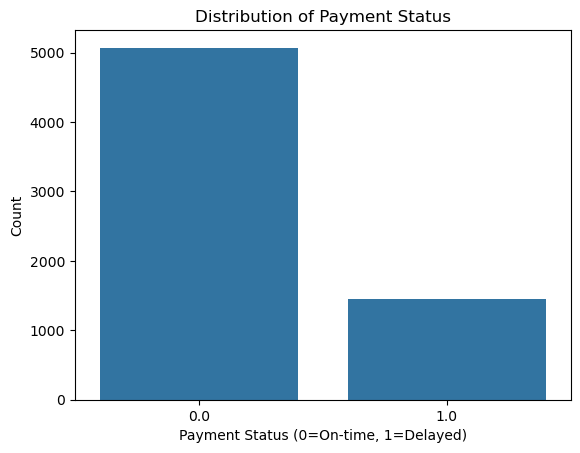

In [12]:
# Feature Engineering and Renaming Columns

# Rename columns for better clarity and consistency
df = df.rename(columns={
    'person_age': 'customer_age',
    'person_income': 'annual_income',
    'person_home_ownership': 'home_ownership',
    'person_emp_length': 'employment_length',
    'loan_intent': 'purchase_intent',
    'loan_grade': 'credit_grade',
    'loan_amnt': 'invoice_amount',
    'loan_int_rate': 'interest_rate',
    'loan_status': 'payment_status',
    'loan_percent_income': 'invoice_to_income_ratio',
    'cb_person_default_on_file': 'historical_default',
    'cb_person_cred_hist_length': 'credit_history_length'
})

# Derive a new feature: ratio of invoice amount to income
df['invoice_to_income_ratio'] = df['invoice_amount'] / df['annual_income']

# Encoding Categorical Variables
# Encode binary categorical feature using LabelEncoder
binary_features = ['historical_default']
encoder = LabelEncoder()
for feature in binary_features:
    df[feature] = encoder.fit_transform(df[feature])

# Apply one-hot encoding to multi-category categorical variables
# 'drop_first=True' avoids multicollinearity by dropping one category per feature
multi_category_features = ['home_ownership', 'purchase_intent', 'credit_grade']
df = pd.get_dummies(df, columns=multi_category_features, drop_first=True)

# Target Variable Distribution Visualization

# Visualize the distribution of the target variable (payment_status)
sns.countplot(x='payment_status', data=df)
plt.title('Distribution of Payment Status')
plt.xlabel('Payment Status (0=On-time, 1=Delayed)')
plt.ylabel('Count')
plt.show()

In [13]:
# Data Scaling: Normalize selected numerical features for better model performance
scaler = StandardScaler()
scaled_features = ['customer_age', 'annual_income', 'employment_length', 'invoice_amount', 
                   'interest_rate', 'invoice_to_income_ratio', 'credit_history_length']

# Ensure only existing columns are scaled to avoid errors
scaled_features = [col for col in scaled_features if col in df.columns]
df[scaled_features] = scaler.fit_transform(df[scaled_features])

# Splitting the dataset into training and testing sets
X = df.drop(columns=['payment_status'])
y = df['payment_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models and their hyperparameters for GridSearchCV
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    }
}

# Train and evaluate each model using GridSearchCV
for model_name, config in models.items():
    print(f"Training {model_name}...")

    # Perform hyperparameter tuning using 5-fold cross-validation
    grid_search = GridSearchCV(config['model'], config['params'], cv=5, scoring='recall', n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Display best hyperparameters and cross-validation score
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best Cross-Validation Score for {model_name}: {grid_search.best_score_:.4f}")

    # Evaluate on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Display confusion matrix and classification report
    print(f"\nConfusion Matrix for {model_name}:")
    print(confusion_matrix(y_test, y_pred))
    print(f"\nClassification Report for {model_name}:")
    print(classification_report(y_test, y_pred))
    print("\n" + "-"*50 + "\n")

Training RandomForest...
,Fitting 5 folds for each of 24 candidates, totalling 120 fits
,Best Parameters for RandomForest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
,Best Cross-Validation Score for RandomForest: 0.7028
,
,Confusion Matrix for RandomForest:
,[[984  19]
, [ 98 203]]
,
,Classification Report for RandomForest:
,              precision    recall  f1-score   support
,
,         0.0       0.91      0.98      0.94      1003
,         1.0       0.91      0.67      0.78       301
,
,    accuracy                           0.91      1304
,   macro avg       0.91      0.83      0.86      1304
,weighted avg       0.91      0.91      0.91      1304
,
,
,--------------------------------------------------
,
,Training GradientBoosting...
,Fitting 5 folds for each of 8 candidates, totalling 40 fits
,Best Parameters for GradientBoosting: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
,Best Cross-Validation Score for GradientBoosting

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
,  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
,131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - Recall: 0.0808 - accuracy: 0.7402 - loss: 0.5590 - val_Recall: 0.4372 - val_accuracy: 0.8447 - val_loss: 0.3770
,Epoch 2/30
,131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Recall: 0.4564 - accuracy: 0.8334 - loss: 0.3989 - val_Recall: 0.4884 - val_accuracy: 0.8629 - val_loss: 0.3565
,Epoch 3/30
,131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Recall: 0.5277 - accuracy: 0.8471 - loss: 0.3611 - val_Recall: 0.5535 - val_accuracy: 0.8677 - val_loss: 0.3439
,Epoch 4/30
,131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Recall: 0.5372 - accuracy: 0.8507 - loss: 0.3719 - val_Recall: 0.5442 - val_accuracy: 0.8725 - val_loss: 0.3371
,Epoch 5/30
,131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Recall: 0.5719 - accuracy: 0.8614 - loss: 0.3448 - val_Recall: 0.5302 - val_accuracy: 0.8734 - val_loss: 0.3347
,Epoch 6/30
,131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - Recall: 0.5691 - accuracy: 0.8676 - loss: 0.3425 - val_Recall: 0.5256 - val_accuracy: 0.8773 - val_loss:

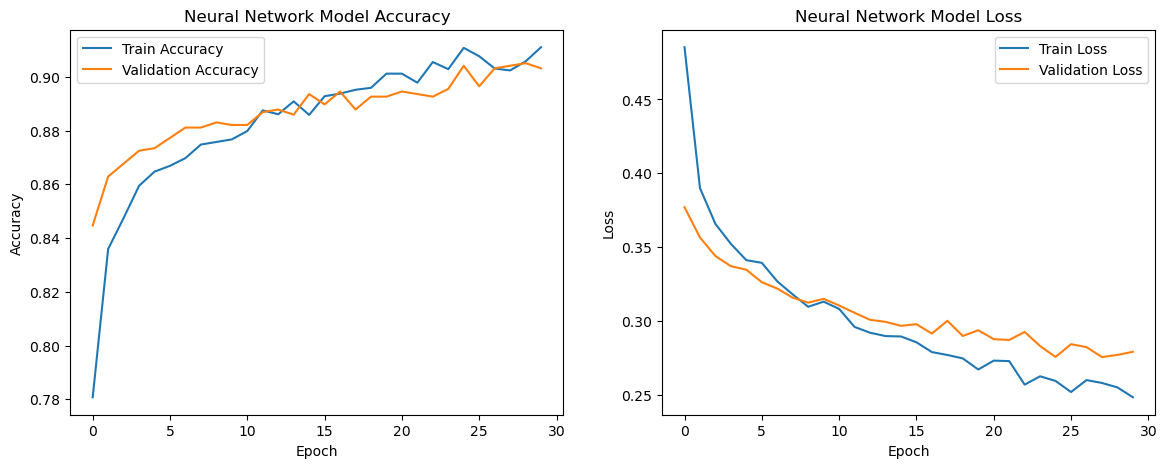

In [14]:
# Define a Neural Network Model using Keras Sequential API
def create_nn_model():
    model = Sequential([
        # Input layer with 64 neurons and ReLU activation
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dropout(0.3),  # Dropout to prevent overfitting

        # Hidden layer with 32 neurons
        Dense(32, activation='relu'),
        Dropout(0.2),  # Additional dropout for regularization

        # Another hidden layer
        Dense(16, activation='relu'),

        # Output layer with sigmoid for binary classification
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with binary crossentropy loss and performance metrics
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', 'Recall'])
    return model

# Initialize the neural network and set up early stopping
nn_model = create_nn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with validation split and early stopping
history = nn_model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=[early_stopping], verbose=1)

# Evaluate model performance on the test set
loss, accuracy, recall = nn_model.evaluate(X_test, y_test)

# Visualize training and validation performance
print(f"Neural Network Test Accuracy: {accuracy:.4f}, Test Recall: {recall:.4f}")

# Accuracy plot
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()